VICTIM DNN MODEL

Epoch 1/30
469/469 [==============================] - 12s 23ms/step - loss: 0.0159 - accuracy: 0.8927 - val_loss: 0.0061 - val_accuracy: 0.9601
Epoch 2/30
469/469 [==============================] - 11s 23ms/step - loss: 0.0079 - accuracy: 0.9485 - val_loss: 0.0050 - val_accuracy: 0.9676
Epoch 3/30
469/469 [==============================] - 11s 24ms/step - loss: 0.0063 - accuracy: 0.9596 - val_loss: 0.0046 - val_accuracy: 0.9701
Epoch 4/30
469/469 [==============================] - 10s 22ms/step - loss: 0.0055 - accuracy: 0.9646 - val_loss: 0.0040 - val_accuracy: 0.9731
Epoch 5/30
469/469 [==============================] - 11s 23ms/step - loss: 0.0050 - accuracy: 0.9680 - val_loss: 0.0039 - val_accuracy: 0.9753
Epoch 6/30
469/469 [==============================] - 12s 25ms/step - loss: 0.0047 - accuracy: 0.9695 - val_loss: 0.0039 - val_accuracy: 0.9747
Epoch 7/30
469/469 [==============================] - 10s 22ms/step - loss: 0.0044 - accuracy: 0.9715 - val_loss: 0.0033 - val_accuracy:

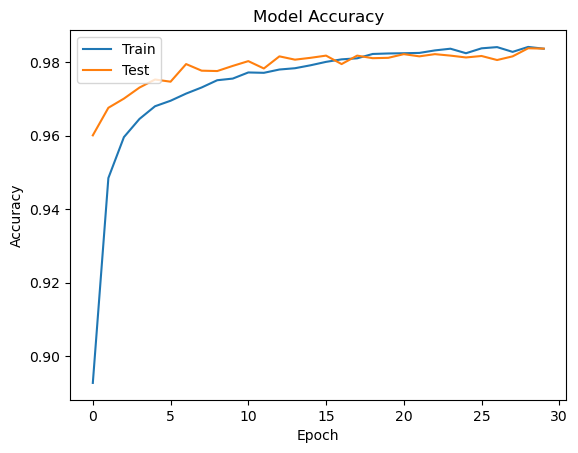

In [1]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np

seed = 42
tf.random.set_seed(seed) #
np.random.seed(seed)

# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Reshape the input images
x_train = x_train.reshape((60000, 784))
x_test = x_test.reshape((10000, 784))

# Convert the pixel values to the range [0, 1]
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert the labels to one-hot encoded vectors
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)


# Define the model architecture
model = tf.keras.Sequential([
    layers.Dense(450, activation='relu', input_shape=(784,)),
    layers.Dropout(0.45),
    layers.Dense(450, activation='relu'),
    layers.Dropout(0.45),
    layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='MSE',
              metrics=['accuracy'])

# Train the model
history=model.fit(x_train, y_train, epochs=30, batch_size=128, validation_data=(x_test, y_test))


# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:',test_acc)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

APPLYING DEFENSE MECHANISMS AGAINST FGSM ATTACK AND MEASURING THE ACCURACY BEFORE AND AFTER ATTACK

In [8]:
import matplotlib.pyplot as plt1
def generate_adversarial_examples(model_copy, x, y, epsilon):
    # Create a copy of the input data to modify
    x_adv = tf.Variable(x, dtype=tf.float32)

    with tf.GradientTape() as tape:
        # Compute the loss between the predicted and true labels
        tape.watch(x_adv)
        
        y_pred = model_copy(x_adv)
        loss = tf.keras.losses.MSE(y, y_pred)
        
        #loss = tf.keras.losses.categorical_crossentropy(y, y_pred)
        #print(loss)
    # Compute the gradients of the loss with respect to the input data
    gradients = tape.gradient(loss, x_adv)

    # Normalize the gradients
    gradients = tf.math.sign(gradients)

    # Add the scaled gradients to the input data to generate the adversarial examples
    x_adv = x_adv + epsilon * gradients
    x_adv = tf.clip_by_value(x_adv, 0, 1)  # Ensure the pixel values are between 0 and 1

    return x_adv.numpy()


def generate_adversarial_examples_gradient_masking(model_copy, x, y, epsilon, alpha=0.01):
    # Apply gradient masking to input data
    x_masked = gradient_masking(x)

    # Compute adversarial examples using FGSM
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    with tf.GradientTape() as tape:
        tape.watch(x_masked)
        y_pred = model_copy(x_masked)
        loss = loss_fn(y, y_pred)
    gradients = tape.gradient(loss, x_masked)
    x_adv = x_masked + alpha * tf.sign(gradients)
    x_adv = tf.clip_by_value(x_adv, 0, 1)

    # Apply perturbation scaling
    x_adv = x + epsilon * (x_adv - x)
    x_adv = tf.clip_by_value(x_adv, 0, 1)

    return x_adv

def gradient_masking(x):
    x = tf.convert_to_tensor(x, dtype=tf.float32)
    with tf.GradientTape() as tape:
        tape.watch(x)
        y_pred = model_copy(x)
        loss = tf.reduce_sum(y_pred)
    gradients = tape.gradient(loss, x)
    return tf.stop_gradient(x - gradients)

def smooth_labels(y, smooth_factor=0.01):
    assert len(y.shape) == 2
    if 0 <= smooth_factor <= 1:
        y *= 1 - smooth_factor
        y += smooth_factor / y.shape[1]
    else:
        raise ValueError('Invalid label smoothing factor: ' + str(smooth_factor))
    return y





def adversarial_training(defense_name,model_copy):
    batch_size = 128
    epochs = 20
    steps_per_epoch = len(x_train) // batch_size
    for epoch in range(epochs):
        print('Epoch:', epoch)
        for step in range(steps_per_epoch):
            # Get batch of training examples
            x_batch = x_train[step*batch_size : (step+1)*batch_size]
            y_batch = y_train[step*batch_size : (step+1)*batch_size]

            # Generate adversarial examples for the batch
            x_adv = defense_name(model_copy, x_batch,y_batch,0.1)
            #x_adv = generate_adversarial_examples(model, x_batch,y_batch,0.1)
            #x_adv = generate_adversarial_examples_gradient_masking(model, x_batch,y_batch,0.1)

            # Concatenate original and adversarial examples
            x_combined = tf.concat([x_batch, x_adv], axis=0)
            y_combined = tf.concat([y_batch, y_batch], axis=0)

            # Train on combined dataset
            model_copy.train_on_batch(x_combined, y_combined)

        # Evaluate performance on test set
        test_loss, test_acc = model.evaluate(x_test, y_test, verbose=0)
        print('Test accuracy:', test_acc)
        
        
def attack(model_copy):
    adv_acc_list=[]

    for i in l:
        x_adv = generate_adversarial_examples(model_copy, x_test, y_test,i)

        # Evaluate the accuracy of the victim model on the adversarial examples
        adv_loss,adv_accu=model_copy.evaluate(x_adv, y_test)
        adv_acc_list.append(adv_accu)

        success_rate = (1 - adv_accu / test_acc) * 100
        print(success_rate)
        #success_rates.append(success_rate)
    return adv_acc_list


l=[0.1,0.2,0.3,0.4]






In [5]:
#accuracy after attack
model_copy = tf.keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())
model_copy.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='MSE',
              metrics=['accuracy'])

list1=attack(model_copy)


313/313 [==============================] - 1s 2ms/step - loss: 0.1019 - accuracy: 0.3918
60.17078424675317
313/313 [==============================] - 1s 2ms/step - loss: 0.1401 - accuracy: 0.1705
82.66747999711824
313/313 [==============================] - 1s 2ms/step - loss: 0.1461 - accuracy: 0.1503
84.72095155118411
313/313 [==============================] - 1s 2ms/step - loss: 0.1499 - accuracy: 0.1409
85.67652697293529


Epoch: 0
Test accuracy: 0.9836999773979187
Epoch: 1
Test accuracy: 0.9836999773979187
Epoch: 2
Test accuracy: 0.9836999773979187
Epoch: 3
Test accuracy: 0.9836999773979187
Epoch: 4
Test accuracy: 0.9836999773979187
Epoch: 5
Test accuracy: 0.9836999773979187
Epoch: 6
Test accuracy: 0.9836999773979187
Epoch: 7
Test accuracy: 0.9836999773979187
Epoch: 8
Test accuracy: 0.9836999773979187
Epoch: 9
Test accuracy: 0.9836999773979187
313/313 [==============================] - 1s 2ms/step - loss: 0.0129 - accuracy: 0.9182
6.658530332535994
313/313 [==============================] - 0s 1ms/step - loss: 0.0489 - accuracy: 0.6695
31.94063142145841
313/313 [==============================] - 1s 2ms/step - loss: 0.1053 - accuracy: 0.2585
73.72166151117077
313/313 [==============================] - 0s 2ms/step - loss: 0.1275 - accuracy: 0.1437
85.39188706661585


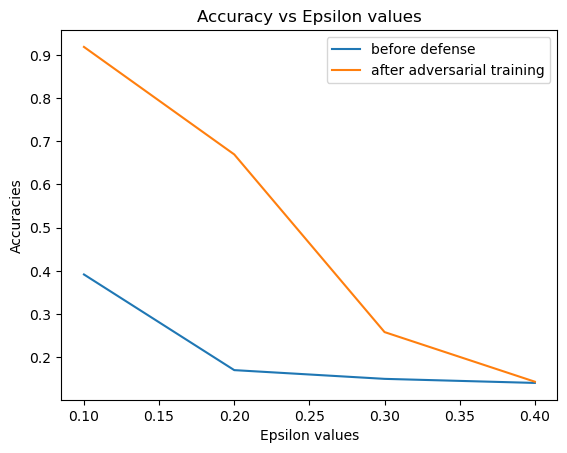

In [6]:
#adversarial training defense
adversarial_training(generate_adversarial_examples,model_copy)

list2=attack(model_copy)

fig, ax = plt1.subplots()
ax.plot(l, list1, label='before defense')
ax.plot(l,list2, label='after adversarial training')
plt1.xlabel('Epsilon values')
plt1.ylabel('Accuracies')
plt1.title('Accuracy vs Epsilon values')
ax.legend()
plt1.show()

Epoch: 0
Test accuracy: 0.9836999773979187
Epoch: 1
Test accuracy: 0.9836999773979187
Epoch: 2
Test accuracy: 0.9836999773979187
Epoch: 3
Test accuracy: 0.9836999773979187
Epoch: 4
Test accuracy: 0.9836999773979187
Epoch: 5
Test accuracy: 0.9836999773979187
Epoch: 6
Test accuracy: 0.9836999773979187
Epoch: 7
Test accuracy: 0.9836999773979187
Epoch: 8
Test accuracy: 0.9836999773979187
Epoch: 9
Test accuracy: 0.9836999773979187
Epoch: 10
Test accuracy: 0.9836999773979187
Epoch: 11
Test accuracy: 0.9836999773979187
Epoch: 12
Test accuracy: 0.9836999773979187
Epoch: 13
Test accuracy: 0.9836999773979187
Epoch: 14
Test accuracy: 0.9836999773979187
Epoch: 15
Test accuracy: 0.9836999773979187
Epoch: 16
Test accuracy: 0.9836999773979187
Epoch: 17
Test accuracy: 0.9836999773979187
Epoch: 18
Test accuracy: 0.9836999773979187
Epoch: 19
Test accuracy: 0.9836999773979187
313/313 [==============================] - 1s 2ms/step - loss: 0.0711 - accuracy: 0.5764
41.40490035384086
313/313 [==============

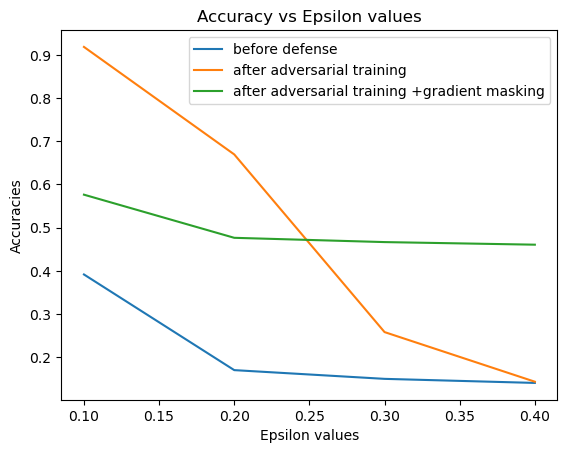

In [9]:
#adversarial training with gradient masking defense on base model
model_copy = tf.keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())
model_copy.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss='MSE',
              metrics=['accuracy'])
adversarial_training(generate_adversarial_examples_gradient_masking,model_copy)
list3=attack(model_copy)

fig, ax = plt1.subplots()
ax.plot(l, list1, label='before defense')
ax.plot(l,list2, label='after adversarial training')
ax.plot(l,list3, label='after adversarial training +gradient masking')
plt1.xlabel('Epsilon values')
plt1.ylabel('Accuracies')
plt1.title('Accuracy vs Epsilon values')
ax.legend()
plt1.show()

In [11]:
#label smoothing defense
model_copy = tf.keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())
y_train_smooth = smooth_labels(y_train, 0.1)
model_copy.compile(loss='MSE', optimizer=tf.keras.optimizers.Adam(0.001), metrics=['accuracy'])
model_copy.fit(x_train, y_train_smooth, epochs=30, batch_size=128, validation_data=(x_test, y_test))

list4=attack(model_copy)

Epoch 1/30
469/469 [==============================] - 11s 20ms/step - loss: 0.0030 - accuracy: 0.9850 - val_loss: 0.0030 - val_accuracy: 0.9817
Epoch 2/30
469/469 [==============================] - 8s 17ms/step - loss: 0.0032 - accuracy: 0.9839 - val_loss: 0.0032 - val_accuracy: 0.9817
Epoch 3/30
469/469 [==============================] - 8s 17ms/step - loss: 0.0031 - accuracy: 0.9851 - val_loss: 0.0029 - val_accuracy: 0.9826
Epoch 4/30
469/469 [==============================] - 7s 15ms/step - loss: 0.0028 - accuracy: 0.9866 - val_loss: 0.0030 - val_accuracy: 0.9820
Epoch 5/30
469/469 [==============================] - 7s 15ms/step - loss: 0.0030 - accuracy: 0.9858 - val_loss: 0.0034 - val_accuracy: 0.9806
Epoch 6/30
469/469 [==============================] - 7s 15ms/step - loss: 0.0029 - accuracy: 0.9860 - val_loss: 0.0029 - val_accuracy: 0.9831
Epoch 7/30
469/469 [==============================] - 8s 17ms/step - loss: 0.0029 - accuracy: 0.9859 - val_loss: 0.0031 - val_accuracy: 0.981

In [12]:
#distilled neural network defense
model_copy = tf.keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())
soft_targets = model_copy.predict(x_train)

student_model = tf.keras.Sequential([
    layers.Dense(200, activation='relu', input_shape=(784,)),
    layers.Dropout(0.3),
    layers.Dense(200, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(10, activation='softmax')
])

# Compile the student model
student_model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Train the student model with soft targets generated by the teacher model
student_model.fit(x_train, soft_targets, epochs=30, batch_size=128, validation_data=(x_test, y_test))

list5=attack(student_model)

adversarial_training(generate_adversarial_examples,student_model)
list6=attack(student_model)


1875/1875 [==============================] - 10s 5ms/step
Epoch 1/30
469/469 [==============================] - 7s 11ms/step - loss: 0.3566 - accuracy: 0.8903 - val_loss: 0.1387 - val_accuracy: 0.9589
Epoch 2/30
469/469 [==============================] - 5s 11ms/step - loss: 0.1446 - accuracy: 0.9549 - val_loss: 0.1079 - val_accuracy: 0.9672
Epoch 3/30
469/469 [==============================] - 6s 13ms/step - loss: 0.1069 - accuracy: 0.9657 - val_loss: 0.0892 - val_accuracy: 0.9729
Epoch 4/30
469/469 [==============================] - 6s 13ms/step - loss: 0.0851 - accuracy: 0.9725 - val_loss: 0.0867 - val_accuracy: 0.9748
Epoch 5/30
469/469 [==============================] - 6s 12ms/step - loss: 0.0731 - accuracy: 0.9765 - val_loss: 0.0804 - val_accuracy: 0.9748
Epoch 6/30
469/469 [==============================] - 6s 12ms/step - loss: 0.0644 - accuracy: 0.9793 - val_loss: 0.0818 - val_accuracy: 0.9772
Epoch 7/30
469/469 [==============================] - 5s 12ms/step - loss: 0.0594 - 

In [13]:
#GDA+ReLu
model_copy = tf.keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())
model_copy.add(layers.BatchNormalization(momentum=5.99,epsilon=0.001))
model_copy.add(layers.Activation('relu'))
model_copy.add(layers.GaussianNoise(0.5))

# Compile your model
model_copy.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
test_loss, test_acc = model_copy.evaluate(x_test, y_test)
print('Test accuracy:',test_acc)

list7=attack(model_copy)

313/313 [==============================] - 2s 6ms/step - loss: 0.0913 - accuracy: 0.9837
Test accuracy: 0.9836999773979187
313/313 [==============================] - 2s 6ms/step - loss: 2.9073 - accuracy: 0.5818
40.855952287683515
313/313 [==============================] - 2s 6ms/step - loss: 7.5404 - accuracy: 0.2532
74.26044521889483
313/313 [==============================] - 2s 7ms/step - loss: 10.6461 - accuracy: 0.1239
87.40469664252609
313/313 [==============================] - 2s 6ms/step - loss: 12.5147 - accuracy: 0.0752
92.35539283897167


In [14]:
#GDA+Brelu defense
class BReLU(layers.Layer):
    def __init__(self, **kwargs):
        super(BReLU, self).__init__(**kwargs)

    def call(self, inputs):
        return tf.maximum(inputs, 0) - tf.maximum(-inputs, 0) + 0.5

    def get_config(self):
        base_config = super(BReLU, self).get_config()
        return base_config

    @classmethod
    def from_config(cls, config):
        return cls(**config)
    
model_copy = tf.keras.models.clone_model(model)
model_copy.set_weights(model.get_weights())
model_copy.add(layers.BatchNormalization(momentum=10,epsilon=0.001))
model_copy.add(BReLU())
#model_copy.add(layers.Activation('relu'))
model_copy.add(layers.GaussianNoise(0.5))

# Compile your model
model_copy.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
test_loss, test_acc = model_copy.evaluate(x_test, y_test)
print('Test accuracy:',test_acc)

list8=attack(model_copy)

313/313 [==============================] - 2s 6ms/step - loss: 1.4044 - accuracy: 0.9837
Test accuracy: 0.9836999773979187
313/313 [==============================] - 2s 6ms/step - loss: 1.7878 - accuracy: 0.6198
36.9929871077156
313/313 [==============================] - 2s 6ms/step - loss: 2.1540 - accuracy: 0.2888
70.64145493747571
313/313 [==============================] - 2s 7ms/step - loss: 2.3006 - accuracy: 0.1590
83.83653572731089
313/313 [==============================] - 2s 7ms/step - loss: 2.3586 - accuracy: 0.1099
88.82789465931586


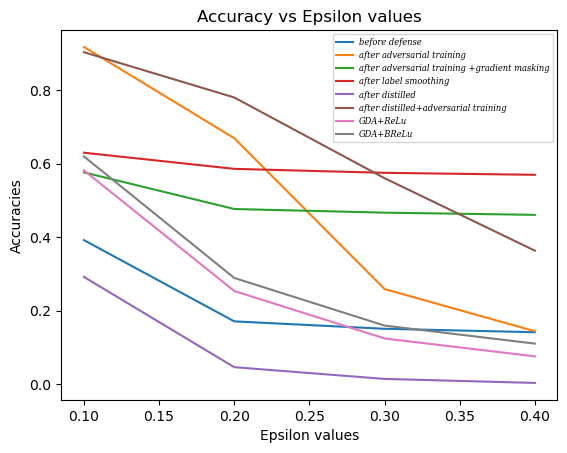

In [18]:
fig, ax = plt1.subplots()
ax.plot(l, list1, label='before defense')
ax.plot(l,list2, label='after adversarial training')
ax.plot(l,list3, label='after adversarial training +gradient masking')
ax.plot(l,list4, label='after label smoothing')
ax.plot(l,list5, label='after distilled')
ax.plot(l,list6, label='after distilled+adversarial training')
ax.plot(l,list7, label='GDA+ReLu')
ax.plot(l,list8, label='GDA+BReLu')
plt1.xlabel('Epsilon values')
plt1.ylabel('Accuracies')
plt1.title('Accuracy vs Epsilon values')
ax.legend(prop={'size': 6, 'family': 'serif', 'style': 'italic'})
plt1.show()